In [1]:
import pandas as pd
from tqdm import tqdm
import os
import seaborn as sns
import re
import joblib

In [2]:
#lets load up the data that we fetched from github api
df=pd.read_csv('table1.csv')
df.head()

,Language,Projects
0,JavaScript,"freeCodeCamp/freeCodeCamp , vuejs/vue , facebo..."
1,Python,"donnemartin/system-design-primer , vinta/aweso..."
2,Ruby,"rails/rails , jekyll/jekyll , discourse/discourse"
3,Java,"CyC2018/CS-Notes , Snailclimb/JavaGuide , iluw..."
4,PHP,"laravel/laravel , blueimp/jQuery-File-Upload ,..."


In [3]:
#init a commit dict object
def get_commit():
    commit = {}
    return commit

#this function parses commits given the output from readline op
#this function is based on the following code
#https://github.com/johnkchiu/GitLogParser/blob/master/gitLogParser.py
def parseCommit(commitLines):
    # dict to store commit data
    commit = get_commit()
    # iterate lines and save
    for nextLine in commitLines:
        # ignore empty lines
        if nextLine == '' or nextLine == '\n':
            pass
        # commit xxxx
        elif bool(re.match('commit', nextLine, re.IGNORECASE)):
            ## new commit, so re-initialize
            if len(commit) != 0:
                #store the previous commit
                commits.append(commit)
                commit = get_commit()
            #store the hash... though i dont think we need this
            commit['hash']= re.match('commit (.*)', nextLine, re.IGNORECASE).group(1)
        #we dont fetch merges
        # Merge: xxxx xxxx
        elif bool(re.match('merge:', nextLine, re.IGNORECASE)):
            pass
        #fetch authors
        elif bool(re.match('author:', nextLine, re.IGNORECASE)):
            # Author: xxxx <xxxx@xxxx.com>
            m = re.compile('Author: (.*) <(.*)>').match(nextLine)
            commit['author'] = m.group(1)
            commit['email'] = m.group(2)
        elif bool(re.match('date:', nextLine, re.IGNORECASE)):
            # Date: xxx
            commit['date'] = nextLine.split('   ')[-1][:-1]
        elif bool(re.match('    ', nextLine, re.IGNORECASE)):
            # (4 empty spaces)
            if commit.get('message') is None:
                commit['message'] = nextLine
            else:
                commit['message'] += nextLine
        # changes to files        
        elif bool(re.match('[-0-9]*(\t)[-0-9]*(\t)*', nextLine, re.IGNORECASE)):
            try:
                addition,subtraction,file_name=nextLine.strip().split('\t')
            #if this happens then that meant there was an error in
            #output of the file and is just a
            #continuation of the message of the commit
            except:
                commit['message'] += nextLine
                continue
            #they put - line diff couldnt be computed    
            addition=int(addition.replace('-','0'))
            subtraction=int(subtraction.replace('-','0'))
            if commit.get('files') is None:
                commit['files']=[]
            commit['files'].append([addition,subtraction,file_name])
        else:
            commit['message'] += nextLine
            #print(commit)
            #print ('ERROR: Unexpected Line: ' + nextLine)
    #if there is only one commit
    if len(commits)==0 and commit.get('hash') is not None:
        commits.append(commit)

        #guess' the language of the file using its extension
def get_language(text):
    if extension.get('.'+text.lower()) is None:
        return False
    else:
        return extension.get('.'+text.lower())
#extracts relevant information from the parsed commits
def get_information(commits):
    #obj for storing all the info
    info={}
    info['message']=[]
    #hash
    info['sha']=[]
    for commit in commits:
        info['sha'].append(commit['hash'])
        try:
            msgs=commit['message'].replace(',',' ')
            msgs=msgs.replace('\n',' ')
            info['message'].append(msgs)
        except:
            info['message'].append('')

    return info

In [ ]:
base_path='insert_base_path_here'

In [6]:
def write_to_csv(language,project,info,filename='commit_message.csv'):
    with open(base_path+filename, 'a') as f:
        for i in range(len(info['sha'])):
            string=str(info['sha'][i])
            string+=','+str(info['message'][i])+'\n'
            f.write(string)

In [24]:
path='commit_message.csv'
f=open(path,'w')
f.write('sha,message\n')
f.close()

In [25]:
#13 mins
counter_idx=0
for language in tqdm(df['Language']):
    language_df=pd.read_csv('language_stats/'+language+'.csv')
    for project in tqdm(language_df['project_name']):
        commits = []
        os.chdir('repo/'+language+'/'+project.replace('/','_')+'/')
        raw_commits=open('commit_history.txt', encoding='utf-8', errors='ignore').readlines()
        parseCommit(raw_commits)
        info=get_information(commits)
        write_to_csv(language,project,info,path)
        os.chdir(base_path)
        

100%|██████████| 17/17 [06:25<00:00, 22.70s/it]


In [8]:
commit_message_df=pd.read_csv('commit_message.csv')
commit_message_df.head()

,sha,message
0,d6c53eb9142d1986e15b09435cb1191bd35c3aae,fix(client): report cross origin errors (#...
1,e154f38118be44b49e9a6a99dd88c447d008f9ac,Added displayUsername and username update ...
2,0f5b9f8764e580566dca1300563cba86359b98da,fix(client): temporary redirect for donati...
3,c40680b81e6c62332392ec6c66ccc5a2b17ebf2e,fix(client): remove donate settings page
4,6a91f7c5b2ba8ea5203bd7d934e07555486ef746,fix(client): add missing bootstrap contain...


In [9]:
commit_message_df['message']=commit_message_df['message'].str.lower()
print(len(commit_message_df))

5331798

In [76]:
commit_message_df['message']=commit_message_df['message'].str[:384]
x=commit_message_df['message'].str.len().fillna(0).tolist()
commit_message_df=commit_message_df.drop_duplicates(subset='message')

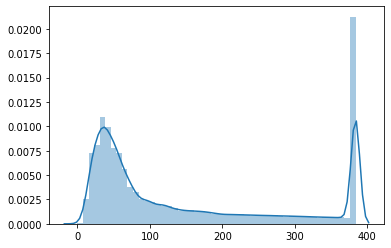

In [77]:
sns.distplot(x,)

In [79]:
commit_message_df.to_csv('dataset_message.csv',index=False)
len(commit_message_df)

4909387

In [80]:
#compressing it because we used a cloud instance to get predictions
!tar -I pigz -cf dataset_message.tgz dataset_message.csv

## Run 5_spacy_predict.ipynb before proceeding to get preds.joblib file

In [81]:
preds=joblib.load('preds.joblib')
commit_message_df['bugfix']=preds
commit_message_df.to_csv('commit_classification.csv',index=False)

In [84]:
commit_message_df=commit_message_df[commit_message_df['bugfix']==1]
commit_message_df.to_csv('bugfix_commits.csv',index=False)

In [86]:
!tar -I pigz -cf bugfix_commits.tgz bugfix_commits.csv

In [87]:
commit_message_df.head(10)

,sha,message,bugfix
0,d6c53eb9142d1986e15b09435cb1191bd35c3aae,fix(client): report cross origin errors (#...,1
1,e154f38118be44b49e9a6a99dd88c447d008f9ac,added displayusername and username update ...,1
2,0f5b9f8764e580566dca1300563cba86359b98da,fix(client): temporary redirect for donati...,1
3,c40680b81e6c62332392ec6c66ccc5a2b17ebf2e,fix(client): remove donate settings page,1
4,6a91f7c5b2ba8ea5203bd7d934e07555486ef746,fix(client): add missing bootstrap contain...,1
6,f1ddec3f9bb5766bfeb88956adda238923d5212e,fix(donate): hide legacy tiers (#37853),1
7,cb3524ee31764dbc02214e11891962356910e708,fix: simplify challenge teststring (#37826),1
8,623c08cbfafac061bfa55a26baec48b581a41b74,fix: removed semi-colon from regex (#37881),1
9,ccbc9cc6b67a8d3db4bba47d4a2d5a0b53badeb4,forum link fixed (#37260),1
10,d40be9cbf254f78d2d125e79f815ccd39df32158,fix: use util.inspect for more reliable lo...,1


In [88]:
len(commit_message_df)

1336878